In [1]:
from google.colab import drive
drive.mount('./gdrive')

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
pd.__version__, np.__version__

('2.2.2', '2.0.2')

TPMをファイルから抽出する。

In [3]:
df_tpm = pd.read_excel('./gdrive/MyDrive/バイオ技術/data/TPM_data.xlsx')

中身を確認してみる

In [4]:
df_tpm.head()

,gene,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
0,seripauperin PAU8,0.00000,0.734587,3.129839,0.000000,0.000000,0.504810
1,hypothetical protein,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,putative permease SEO1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,hypothetical protein,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,hypothetical protein,0.94849,2.799529,4.969954,4.689762,4.372026,8.657291


In [5]:
tpm = df_tpm.drop('gene', axis=1)
log_tpm = np.log2(tpm + 1.0)

In [6]:
# 転置
tpm_t = tpm.T
tpm_t.head()

,0,1,2,3,4,5,6,7,8,9,...,5973,5974,5975,5976,5977,5978,5979,5980,5981,5982
batch_1,0.000000,0.0,0.0,0.0,0.948490,0.0,0.0,0.0,1.456789,8.547801,...,19.276063,9.855674,11.125124,56.907662,29.604144,9.655050,4.758844,7.056131,0.000000,5.364065
batch_2,0.734587,0.0,0.0,0.0,2.799529,0.0,0.0,0.0,1.242913,7.956960,...,9.617404,6.868391,9.435781,49.017497,28.925308,8.142143,6.474344,9.111649,2.588885,6.840622
batch_3,3.129839,0.0,0.0,0.0,4.969954,0.0,0.0,0.0,1.574382,8.130975,...,10.567662,8.033253,11.926834,52.327951,28.242816,7.227299,5.298830,12.940596,0.612800,9.226409
chemostat_1,0.000000,0.0,0.0,0.0,4.689762,0.0,0.0,0.0,3.226353,159.953635,...,10.062334,24.365443,20.654201,50.545687,42.062127,12.881928,18.627810,7.476147,1.927507,11.243170
chemostat_2,0.000000,0.0,0.0,0.0,4.372026,0.0,0.0,0.0,3.777192,159.681219,...,9.937716,26.680713,20.546002,41.847681,56.196940,13.321091,17.039334,11.616052,0.770107,11.364486


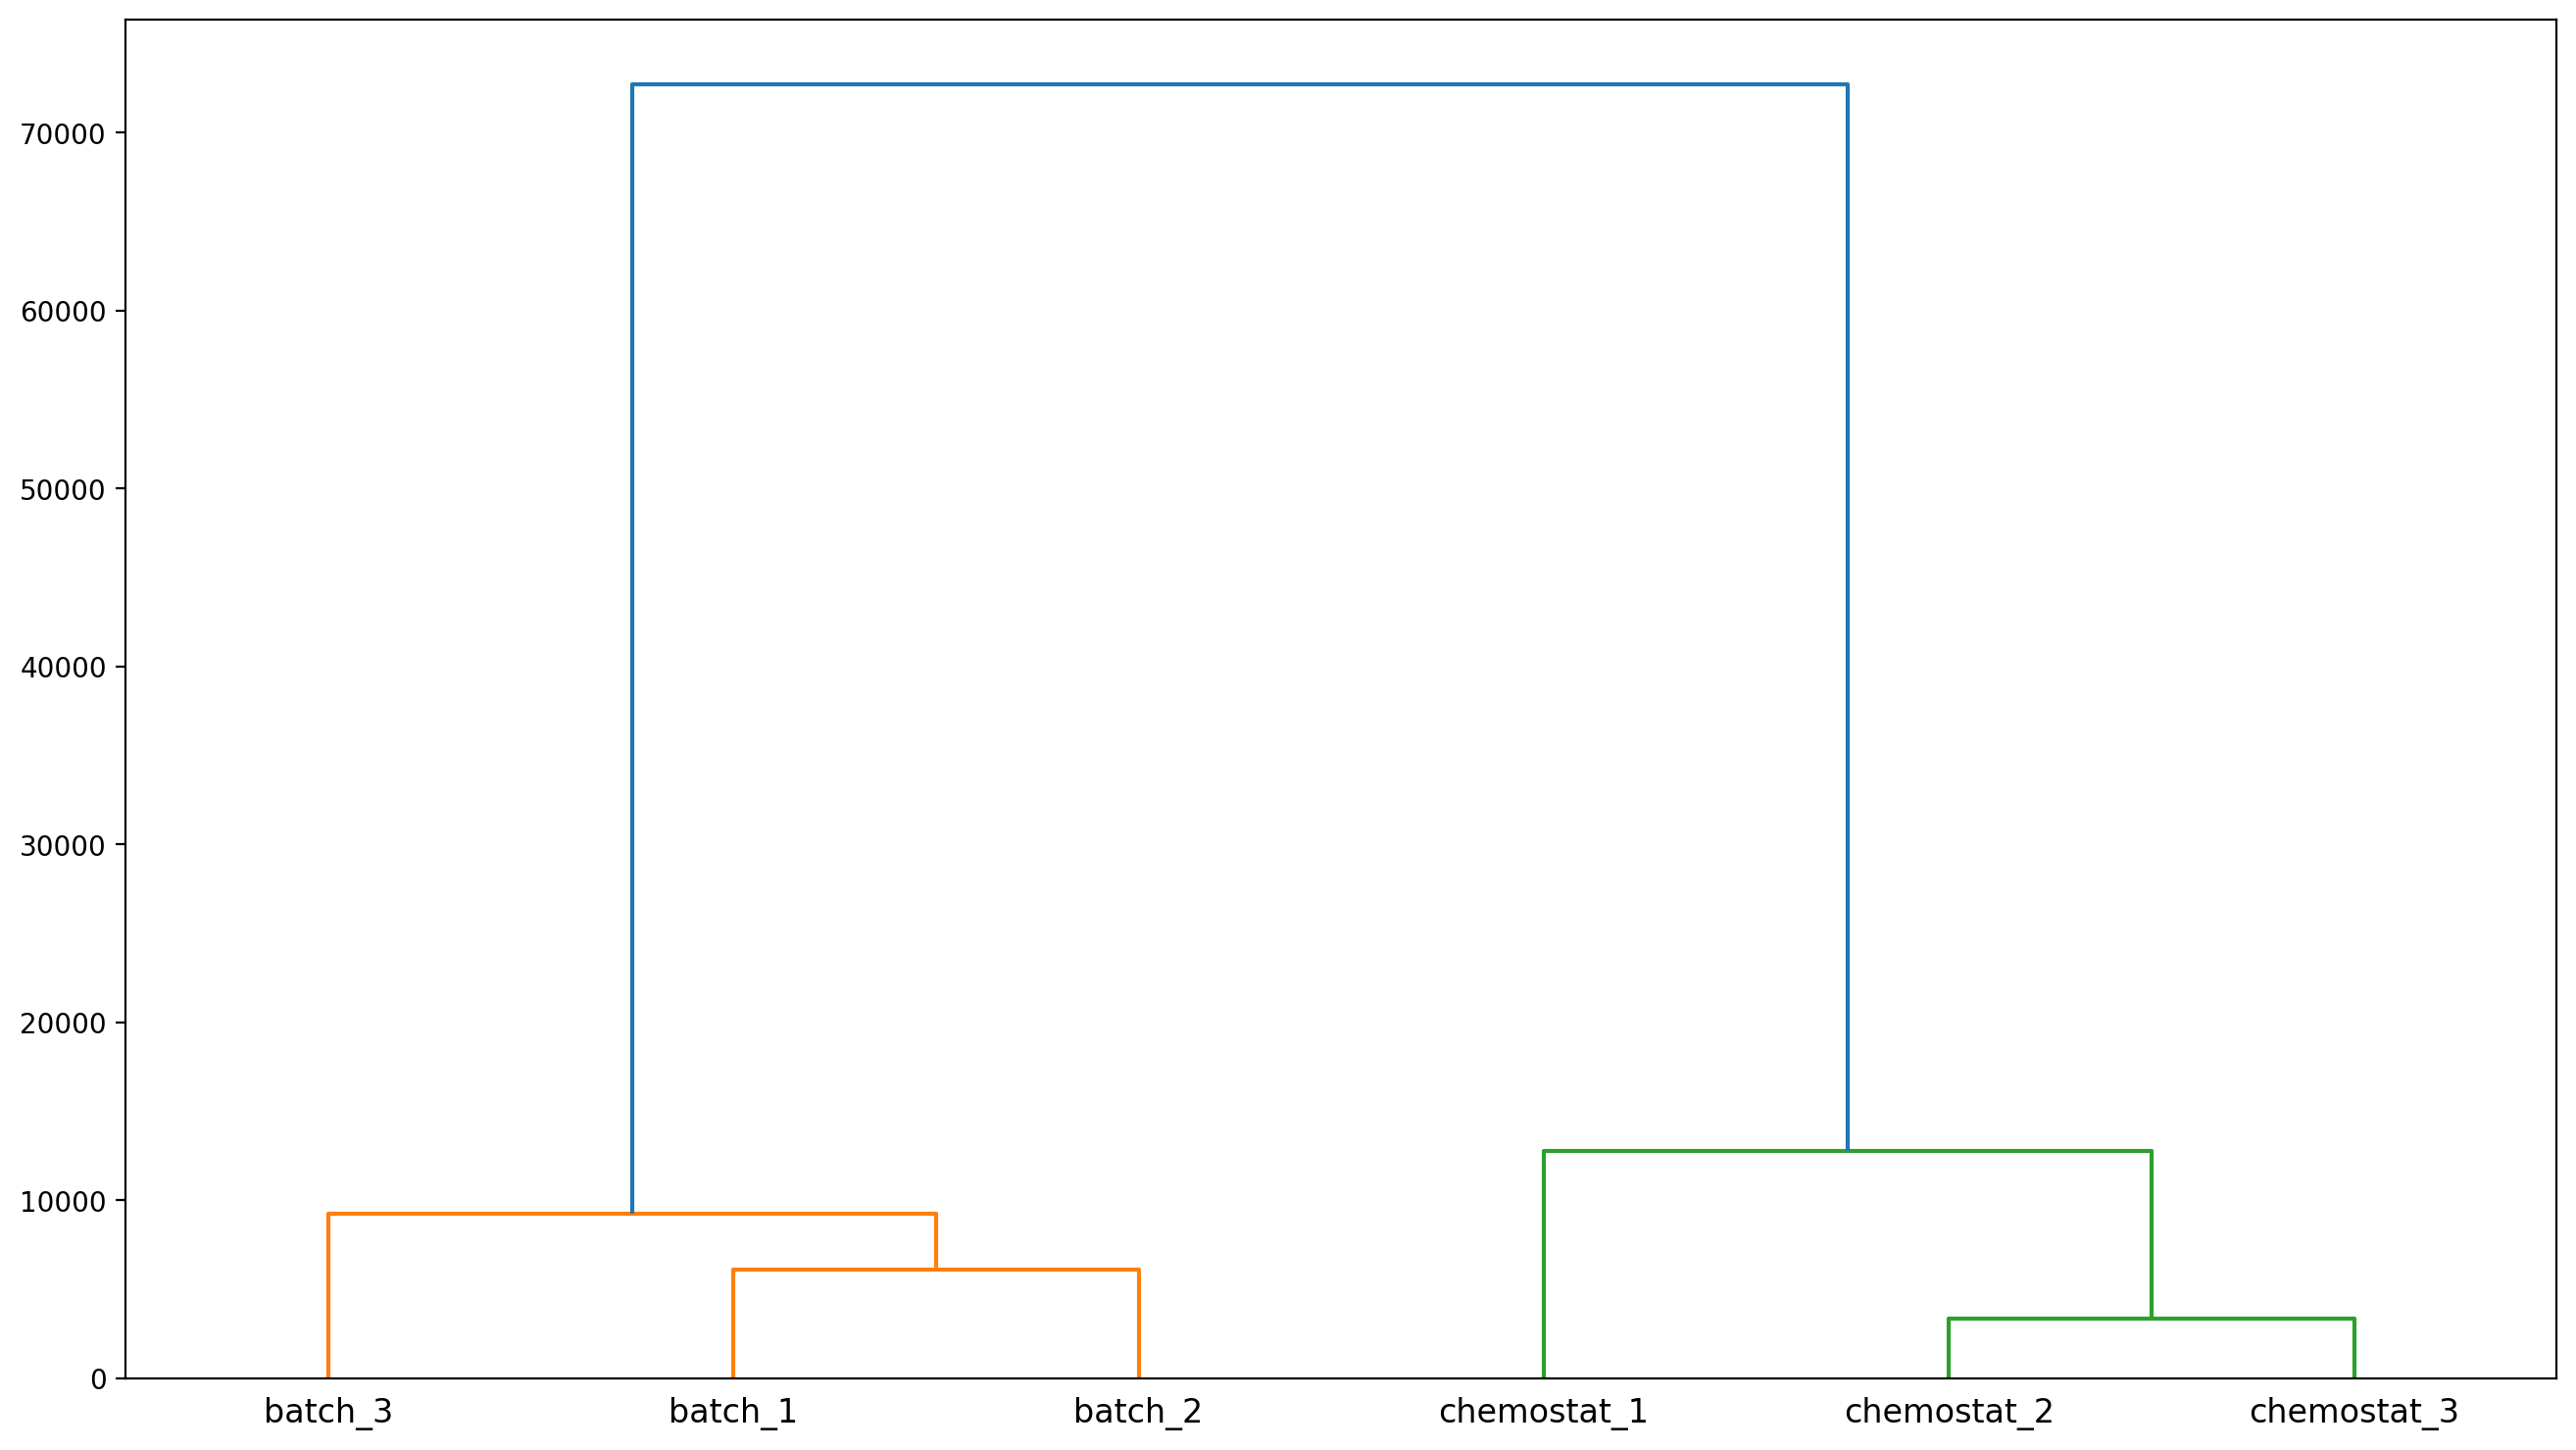

In [7]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# matplotlib=3.8.4, scipy=1.13.1
linkage_result = linkage(tpm_t, method='ward', metric='euclidean')
plt.figure(num=None, figsize=(16, 9), dpi=200, facecolor='w', edgecolor='k')
dendrogram(linkage_result, labels=list(tpm_t.index))
plt.show()

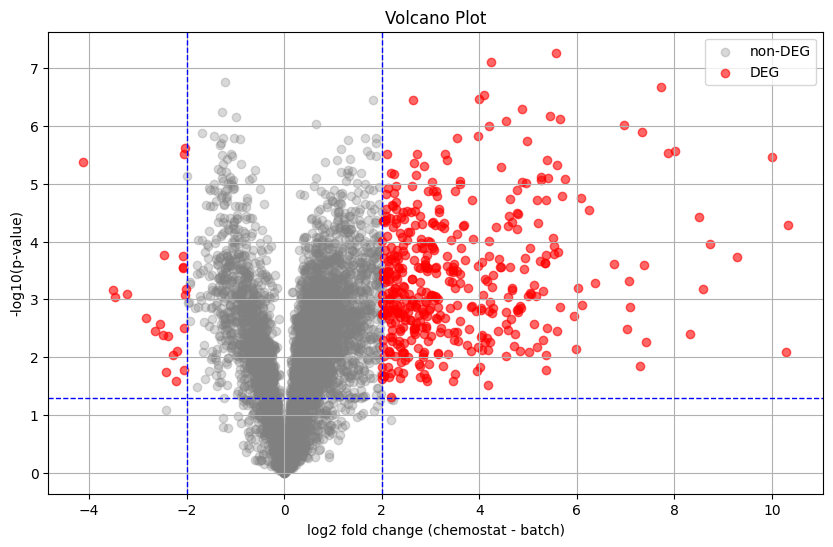

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# 仮に tpm DataFrame に 6サンプル（前半3つが batch、後半3つが chemostat）あると仮定
batch = tpm.iloc[:, :3]
chemostat = tpm.iloc[:, 3:]

# log2(TPM + 1) に変換
log_batch = np.log2(batch + 1)
log_chemo = np.log2(chemostat + 1)

# 各遺伝子について Welch のt検定を行い、fold changeとp値を計算
log2fc = log_chemo.mean(axis=1) - log_batch.mean(axis=1)
pvals = []
for i in range(len(tpm)):
    stat, pval = ttest_ind(log_batch.iloc[i], log_chemo.iloc[i], equal_var=False)
    pvals.append(pval)

pvals = np.array(pvals)
neg_log10_pvals = -np.log10(pvals)

# DEGフラグ（fold change > 2 かつ p < 0.05）
is_DEG = (np.abs(log2fc) > 2) & (pvals < 0.05)

# --- ボルケーノプロット ---
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()

# 非DEG（灰色）
ax.scatter(log2fc[~is_DEG], neg_log10_pvals[~is_DEG],
           color='gray', alpha=0.3, label='non-DEG')

# DEG（赤）
ax.scatter(log2fc[is_DEG], neg_log10_pvals[is_DEG],
           color='red', alpha=0.6, label='DEG')

# 軸としきい値ライン
ax.axhline(-np.log10(0.05), color='blue', linestyle='--', linewidth=1)
ax.axvline(2, color='blue', linestyle='--', linewidth=1)
ax.axvline(-2, color='blue', linestyle='--', linewidth=1)

ax.set_xlabel('log2 fold change (chemostat - batch)')
ax.set_ylabel('-log10(p-value)')
ax.set_title('Volcano Plot')
ax.legend()
plt.show()


DEGをp値でソートして出力

In [9]:
# gene列を使って、元のデータに計算結果を統合
results_df = df_tpm[['gene']].copy()
results_df['log2FC'] = log2fc
results_df['pval'] = pvals
results_df['-log10(pval)'] = -np.log10(pvals)
results_df['is_DEG'] = is_DEG

# DEGの行だけ抽出して、p値でソート
deg_df = results_df[results_df['is_DEG']].sort_values(by='pval')

# 上位10件だけ表示（必要に応じて全件表示も可能）
print(deg_df.head(10))

# CSVに出力する場合（Google Colabならこのファイルがダウンロード可能）
deg_df.to_csv("DEG_list_sorted_by_pvalue.csv", index=False)


                                                   gene    log2FC  \
1162                                         catalase A  5.571445   
5926                                              Sue1p  4.231303   
4543                         alcohol dehydrogenase ADH2  7.723890   
9                glutamate dehydrogenase (NADP(+)) GDH3  4.089283   
2760                                              Xbp1p  4.004069   
2431                                              Dur3p  2.632185   
4313                                              Isf1p  4.875161   
3484  bifunctional hydroxyacyl-CoA dehydrogenase/eno...  5.447275   
1993                                              Gpg1p  5.654908   
1815                                              Igd1p  4.546918   

              pval  -log10(pval)  is_DEG  
1162  5.406710e-08      7.267067    True  
5926  7.705177e-08      7.113217    True  
4543  2.125730e-07      6.672492    True  
9     2.890303e-07      6.539057    True  
2760  3.359807e-07      6